In [131]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [132]:
dataset = 'datasets/keypoint1000.csv'
model_save_path = 'models/keypoint_classifier.hdf5'
tflite_save_path = 'models/keypoint_classifier.tflite'

# Set number of classes

In [133]:
NUM_CLASSES = 12
LABELS = ['call', 'dislike', 'fist', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'rock', 'stop', 'stop_inverted'] 

# Dataset reading

In [134]:
def apply_rotation(label, points):
    num_points = 21
    point_0 = points[0]
    point_8 = points[8]

    if label == 'dislike' or label == 'like':
        return points  # No rotation
    elif label == 'call':
        # Rotate to be parallel with X-axis
        line = point_8 - point_0
        angle = np.arctan2(line[2], line[0])  # Consider the X-Z plane
        rotation_matrix = np.array([
            [1, 0, 0],
            [0, np.cos(angle), -np.sin(angle)],
            [0, np.sin(angle), np.cos(angle)]
        ])
    else:
        # Rotate to be parallel with Y-axis
        line = point_8 - point_0
        angle = np.arctan2(line[2], line[1])  # Consider the Y-Z plane
        rotation_matrix = np.array([
            [np.cos(angle), 0, np.sin(angle)],
            [0, 1, 0],
            [-np.sin(angle), 0, np.cos(angle)]
        ])
    
    # Apply rotation
    for i in range(num_points):
        points[i] = np.dot(rotation_matrix, points[i])

    return points


In [135]:
def pre_process_dataset(X_dataset, y_dataset):
    # Reshape to 3D
    num_points = 21
    reshaped_dataset = X_dataset.reshape(-1, num_points, 3)

    # Shift coordinates
    for i in range(len(reshaped_dataset)):
        base_point = reshaped_dataset[i, 0]  # ID:0
        for j in range(num_points):
            reshaped_dataset[i, j] -= base_point

    # Rotation
    for i in range(len(reshaped_dataset)):
        label = LABELS[y_dataset[i]]
        reshaped_dataset[i] = apply_rotation(label, reshaped_dataset[i])

    # Flatten
    flattened_dataset = reshaped_dataset.reshape(-1, num_points * 3)

    # Normalization
    max_abs_value = np.max(np.abs(flattened_dataset))
    normalized_dataset = flattened_dataset / max_abs_value

    return normalized_dataset

In [136]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 3) + 1)))

In [137]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [138]:
X_dataset_preprocessed = pre_process_dataset(X_dataset, y_dataset)

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset_preprocessed, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [140]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dropout(0.1),  # Adjusted dropout rate
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dense(64, activation='relu'),  # Increased units
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [141]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_10 (Dropout)        (None, 63)                0         
                                                                 
 dense_19 (Dense)            (None, 128)               8192      
                                                                 
 batch_normalization_9 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_10 (Bat  (None, 128)              512       
 chNormalization)                                     

In [142]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1)

In [143]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [144]:
es_callback

In [145]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


57/71 [=======================>......] - ETA: 0s - loss: 2.3588 - accuracy: 0.1964
Epoch 1: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 1s 6ms/step - loss: 2.2884 - accuracy: 0.2176 - val_loss: 2.3861 - val_accuracy: 0.1290
Epoch 2/1000
59/71 [=======================>......] - ETA: 0s - loss: 1.8208 - accuracy: 0.3640
Epoch 2: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 1.8072 - accuracy: 0.3641 - val_loss: 2.1898 - val_accuracy: 0.1867
Epoch 3/1000
54/71 [=====================>........] - ETA: 0s - loss: 1.6418 - accuracy: 0.4188
Epoch 3: saving model to models\keypoint_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 1.6348 - accuracy: 0.4222 - val_loss: 1.7571 - val_accuracy: 0.4407
Epoch 4/1000
67/71 [===========================>..] - ETA: 0s - loss: 1.5358 - accuracy: 0.4569
Epoch 4: saving model to models\keypoint_classifier.hdf5
71/71 [=======

In [146]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

24/24 [==============================] - 0s 2ms/step - loss: 0.1835 - accuracy: 0.9357


In [147]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [148]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 76ms/step
[1.8489058e-12 9.9999905e-01 1.4410316e-15 1.4488621e-18 1.7922877e-12
 2.2842302e-07 6.8713497e-13 4.4310062e-07 3.4167353e-09 2.0696334e-07
 4.2993666e-09 1.0101464e-10]
1


# Confusion matrix

94/94 [==============================] - 0s 777us/step


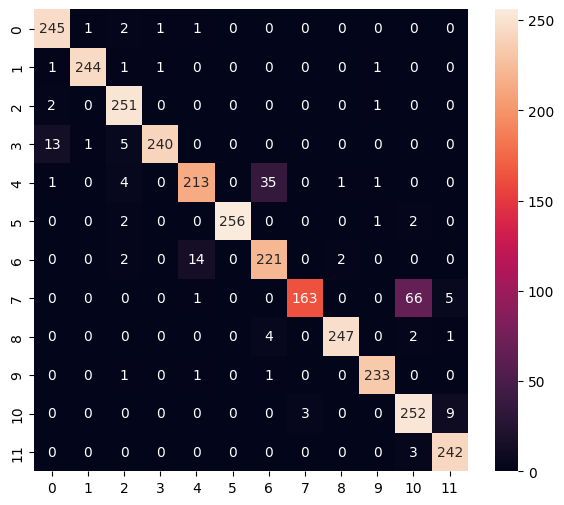

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       250
           1       0.99      0.98      0.99       248
           2       0.94      0.99      0.96       254
           3       0.99      0.93      0.96       259
           4       0.93      0.84      0.88       255
           5       1.00      0.98      0.99       261
           6       0.85      0.92      0.88       239
           7       0.98      0.69      0.81       235
           8       0.99      0.97      0.98       254
           9       0.98      0.99      0.99       236
          10       0.78      0.95      0.86       264
          11       0.94      0.99      0.96       245

    accuracy                           0.94      3000
   macro avg       0.94      0.93      0.93      3000
weighted avg       0.94      0.94      0.94      3000



In [149]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [150]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [151]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\renyi\AppData\Local\Temp\tmppz9o8iog\assets


INFO:tensorflow:Assets written to: C:\Users\renyi\AppData\Local\Temp\tmppz9o8iog\assets


40376

# Inference test

In [152]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [153]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [154]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [155]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [156]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.15209665e-12 9.99999404e-01 1.02577715e-16 6.19779291e-19
 5.07299931e-13 1.29100339e-08 3.08086456e-13 3.25951788e-07
 1.67733261e-09 2.62880008e-07 3.01378167e-09 2.09753867e-10]
1
